In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.chdir('..')

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pickle
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from modules.representation_schemes import enc1d_features, get_PTR_features, get_vectorized_featues, properties_from_comp
from modules.model_select import get_scoring_dict, model_pipeline,rmse, corr
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Rectangle

In [4]:
hardness_df_loc = 'dataset/hardness.csv'
hardness_df = pd.read_csv(hardness_df_loc)
comps = hardness_df['Composition'].values
y = hardness_df['HV'].values
samples_per_bin, bins, = np.histogram(hardness_df['HV'], bins=np.arange(100,1000,100))    # Doane's method worked best for me
min_bin_size = samples_per_bin.min()
# compute the maximum batch size possible, using all samples from the bin with lowest population
n_bins = len(samples_per_bin)
hardness_df['bin_name'] = np.digitize(hardness_df['HV'].values,bins)

In [5]:
results_loc = 'results/hea_hardness_transfer'
if not os.path.exists(results_loc):
    os.mkdir(results_loc)

## Explaining different variances

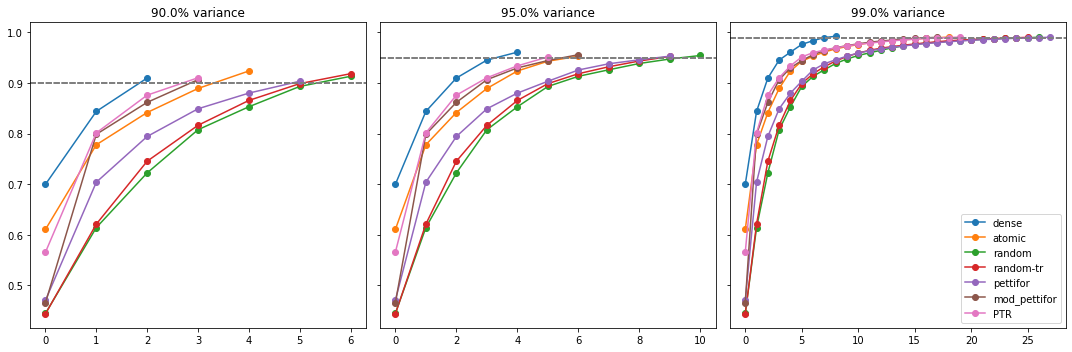

In [6]:
np.random.seed(0)
methods = ['dense','atomic','random','random-tr','pettifor','mod_pettifor','PTR']
names = ['DNN','CNN1-atom','CNN1-alph','CNN1-rand','CNN1-pet','CNN1-modpet','CNN2-PTR']
fig, ax  = plt.subplots(1,3, sharey=True, sharex = False, figsize = (15,5))
ax = ax.ravel()
variance_levels = [0.90,0.95,0.99]
var_dict, pca_dict = {},{}
for j,v in enumerate(variance_levels):
    component_dict_var = {}
    for i, method in enumerate(methods):
        if method == 'atomic':
            extracted = enc1d_features(comps,'atomic')
        elif method == 'random':
            extracted = enc1d_features(comps,'random')
        elif method == 'random-tr':
            extracted = enc1d_features(comps,'random-tr')
        elif method == 'pettifor':
            extracted = enc1d_features(comps,'pettifor')
        elif method == 'mod_pettifor':
            extracted = enc1d_features(comps,'mod_pettifor')
        elif method == 'PTR':
            extracted = get_PTR_features(comps)
        elif method == 'dense':
            extracted = enc1d_features(comps,'dense')
        pca = PCA()
        features = pca.fit_transform(extracted)
        ind = np.argmax(np.cumsum(pca.explained_variance_ratio_)>=v)
        ax[j].plot(np.cumsum(pca.explained_variance_ratio_)[:ind+1],marker = 'o', label =method)
        ax[j].axhline(y=v, color='grey', linestyle='dashed')
        #ax[j].text(16, 0.8, f'{v*100}% cut-off', color = 'grey', fontsize=10)
        ax[j].set_title(f'{v*100}% variance',y=1)
        component_dict_var[method] = ind
        pca_dict[method] = pca.explained_variance_ratio_.tolist()
    var_dict[v] = component_dict_var
#fig.text(0.5, -0.04, 'number of components', ha='center', fontsize=14)
#fig.text(-0.04, 0.5, 'cumulative explained variance', va='center', rotation='vertical', fontsize=14)
plt.tight_layout()
plt.legend()
with open(os.path.join(results_loc,'pca_results_hardness.pkl'),'wb') as fid:
    pickle.dump(var_dict,fid)
with open(os.path.join(results_loc,'pca_results_hardness.json'),'w') as fid:
    json.dump(pca_dict,fid)

## Model selection

In [8]:
np.random.seed(0)
component_dict = var_dict[0.95]
methods = ['atomic','random','random-tr','pettifor','mod_pettifor','PTR','dense']
method_dict = {}
mean_score_list = []
std_score_list = []
for i, method in enumerate(methods):
    print('{}'.format(method))
    if method == 'atomic':
        extracted = enc1d_features(comps,'atomic')
    elif method == 'random':
        extracted = enc1d_features(comps,'random')
    elif method == 'random-tr':
        extracted = enc1d_features(comps,'random-tr')
    elif method == 'pettifor':
        extracted = enc1d_features(comps,'pettifor')
    elif method == 'mod_pettifor':
        extracted = enc1d_features(comps,'mod_pettifor')
    elif method == 'PTR':
        extracted = get_PTR_features(comps)
    elif method ==' dense':
        extracted = enc1d_features(comps,'dense')
    ind = component_dict[method]
    pca = PCA(n_components=ind, whiten=True)
    features = pca.fit_transform(extracted)
    pipelines, scoring_dict = model_pipeline(), get_scoring_dict()
    #X_train, X_test, y_train, y_test = train_test_split(features, y.ravel(), test_size=0.20,random_state = 0,stratify=hardness_df['bin_name'])
    rmse = {'train':[],'test':[]}
    r = {'train':[],'test':[]}
    train_rmse_results = []
    train_r_results = []
    test_rmse_results = []
    test_r_results = []
    names = []
    for name, model in pipelines:
        kfold = KFold(n_splits=10, random_state=21, shuffle=True)
        cv_results = cross_validate(model, features, y, cv=kfold, scoring=scoring_dict,return_train_score=True)
        rmse['train'].append(list(cv_results['train_rmse']))
        r['train'].append(list(cv_results['train_r']))
        rmse['test'].append(list(cv_results['test_rmse']))
        r['test'].append(list(cv_results['test_r']))
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results['test_r'].mean(), cv_results['test_r'].std())
        print(msg)
    method_dict[method] = {'rmse':rmse,'r':r}
save_loc = 'results/model_selection_hardness.json'
with open(save_loc,'w') as fid:
    json.dump(method_dict,fid)


atomic
Linear: 0.885542 (0.040111)
Lasso: 0.885616 (0.040456)
Ridge: 0.885551 (0.040118)
KNeighbor: 0.914754 (0.040737)
GBR: 0.919442 (0.020897)
RF: 0.923758 (0.026897)
XGB: 0.916365 (0.028541)
SVR-lin: 0.884450 (0.038084)
SVR-poly: 0.598012 (0.160392)
SVR-rbf: 0.855095 (0.038380)
MLP: 0.781779 (0.087584)
MLP2: 0.889654 (0.053002)
random
Linear: 0.854535 (0.036852)
Lasso: 0.854932 (0.037012)
Ridge: 0.854543 (0.036852)
KNeighbor: 0.909870 (0.033006)
GBR: 0.917717 (0.034266)
RF: 0.928166 (0.017113)
XGB: 0.920868 (0.040493)
SVR-lin: 0.853505 (0.036326)
SVR-poly: 0.514747 (0.131489)
SVR-rbf: 0.826017 (0.041655)
MLP: 0.711520 (0.084492)
MLP2: 0.887022 (0.042706)
random-tr
Linear: 0.827946 (0.056068)
Lasso: 0.827928 (0.056682)
Ridge: 0.827952 (0.056071)
KNeighbor: 0.877865 (0.041123)
GBR: 0.872488 (0.063756)
RF: 0.884814 (0.049469)
XGB: 0.886182 (0.037009)
SVR-lin: 0.825267 (0.046218)
SVR-poly: 0.493395 (0.122250)
SVR-rbf: 0.763924 (0.053719)
MLP: 0.720403 (0.095467)
MLP2: 0.849238 (0.074690

In [9]:
def get_metrics(pipelines):
    metric_list = []
    for i in range(len(pipelines)):
       metric_list.append(pipelines[i][0])
    return metric_list

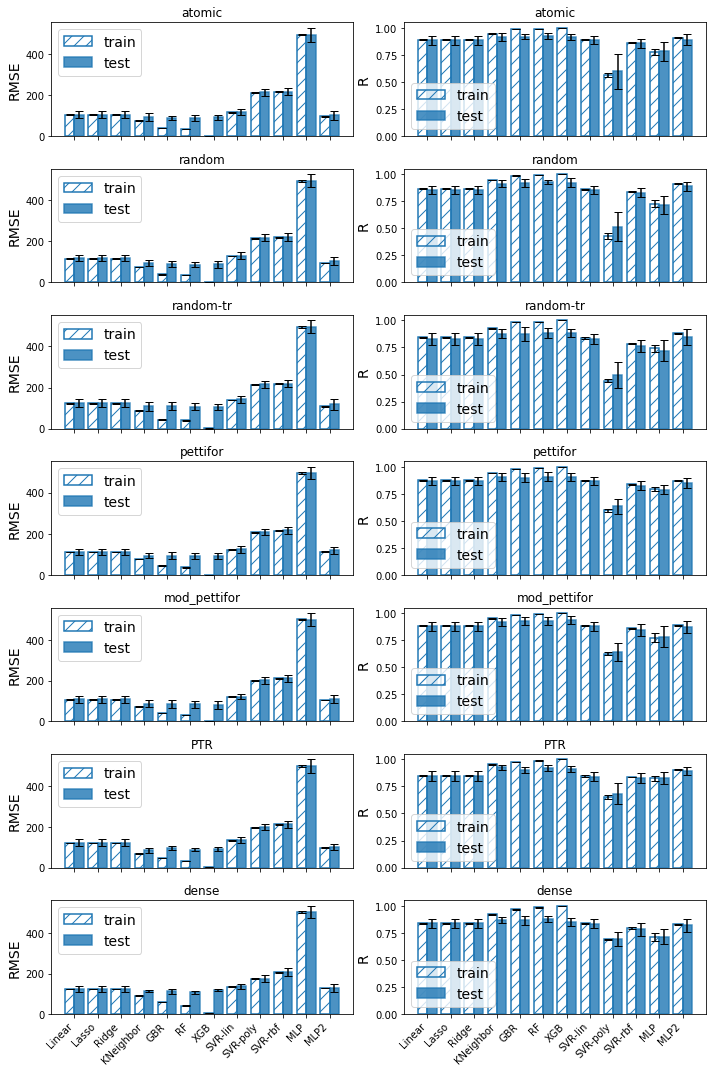

In [10]:
methods = ['atomic','random','random-tr','pettifor','mod_pettifor','PTR','dense']
metrics = get_metrics(pipelines)
scores= ['rmse','r']
fig, ax = plt.subplots(len(methods),2,figsize=(10,15), sharex=True)
#ax = ax.flatten()
for m,method in enumerate(methods):
    for i in range(len(scores)):
        metric = scores[i]
        rmse = method_dict[method]['rmse']
        r = method_dict[method]['r']
        for k, key in enumerate(['train','test']):
            if key == 'train':
                mf = 'none'
                h = '//'
                a = 1.0
            else:
                mf = 'tab:blue'
                h = ''
                a = 0.8
            if metric == 'rmse':
                avg = -np.mean(rmse[key],axis=1)
                std = np.std(rmse[key],axis=1)
            elif metric == 'r':
                avg = np.mean(r[key],axis=1)
                std = np.std(r[key],axis=1)
            ax[m,i].bar(np.arange(len(metrics))+0.2*(2*k-1),avg,yerr = std,facecolor=mf, alpha=a, hatch=h, 
            width=0.40, color='tab:blue', edgecolor='tab:blue', linewidth=1.5, capsize=4,label=key)
            ax[m,i].set_xticks(np.arange(len(metrics)))
            ax[m,i].set_xticklabels(metrics, rotation=45, ha='right')
            ax[m,i].legend(fontsize=14)
            if metric == 'rmse':
                #ax.set_ylim(0, 5)
                ax[m,i].set_ylabel('RMSE',fontsize=14)
            elif metric == 'r':
                #ax.set_ylim(0, 1.01)
                ax[m,i].set_ylabel('R',fontsize=14)
            ax[m,i].set_title(method,y=1)
fig.tight_layout()

#plt.savefig('comp_vec_models.pdf')

## Using RandomForest as model

In [7]:
#fixed folds
np.random.seed(0)
kfold_loc = 'misc/CV_folds/hea_hardness_kfold.pkl'
create_new = False
if os.path.exists(kfold_loc) and not create_new:
    with open(kfold_loc,'rb') as fid:
        fold_dict = pickle.load(fid)
    print('Fold dictionary loaded!')
else:
    fold_dict = {}
    kfold = KFold(n_splits = 10, random_state = 0, shuffle=True)
    for i,(train_index, test_index) in enumerate(kfold.split(comps)):
        #print("TRAIN:", train_index, "TEST:", test_index)
        fold_dict[i] = {'train_inds':train_index, 'test_inds':test_index}
    with open(kfold_loc,'wb') as fid:
        pickle.dump(fold_dict,fid)
    print('Fold dictionary created!')

Fold dictionary loaded!


#### baseline

In [8]:
from modules.function import data_generator_vec, pymatgen_comp
from modules.model_select import get_scoring_dict, model_pipeline,rmse, corr
from sklearn.neural_network import MLPRegressor
dset = data_generator_vec(pymatgen_comp(comps))
features = dset.real_data

baseline_rmse_list = []
baseline_r_list = []
for i in fold_dict.keys():
        baseline_model = Pipeline([('Scaler', StandardScaler()),('MLPC',MLPRegressor((42,42,42),random_state=0,batch_size=64))])
        i_tr, i_te = fold_dict[i]['train_inds'], fold_dict[i]['test_inds']
        X_train, X_test = features[i_tr], features[i_te]
        y_train, y_test = y[i_tr], y[i_te]
        #print('\n\n 5-fold cross-validation: No.'+str(k+1))
        baseline_model.fit(X_train, y_train)
        yte_pred=baseline_model.predict(X_test)
        baseline_rmse_list.append(rmse(yte_pred,y_test))
        baseline_r_list.append(corr(yte_pred,y_test))
    
baseline_rmse = np.mean(baseline_rmse_list)
baseline_rmse_std = np.std(baseline_rmse_list)
baseline_r = np.mean(baseline_r_list)
baseline_r_std = np.std(baseline_r_list)

In [9]:
baseline_dict = {'rmse':baseline_rmse_list,'r':baseline_r_list}
with open(os.path.join(results_loc,'hea_hardness_baseline.json'),'w') as fid:
    json.dump(baseline_dict,fid)

### Fixed PCA components

In [10]:
methods = ['RF','dense','atomic','random','random-tr','pettifor','mod_pettifor','PTR']
dset = data_generator_vec(pymatgen_comp(comps))
scoring_dict = get_scoring_dict()
fixed_inds = [5,10,20]
ind_dict = {}
for ind in fixed_inds:
    print(f'{ind} components')
    method_dict = {}
    mean_score_list = []
    std_score_list = []
    for i, method in enumerate(methods):
        print(f'{method}')
        if method == 'RF':
            features = dset.real_data
        else:
            if method == 'atomic':
                extracted = enc1d_features(comps,'atomic')
            elif method == 'random':
                extracted = enc1d_features(comps,'random')
            elif method == 'random-tr':
                extracted = enc1d_features(comps,'random-tr')
            elif method == 'pettifor':
                extracted = enc1d_features(comps,'pettifor')
            elif method == 'mod_pettifor':
                extracted = enc1d_features(comps,'mod_pettifor')
            elif method == 'PTR':
                extracted = get_PTR_features(comps)
            elif method =='dense':
                extracted = enc1d_features(comps,'dense')
            pca = PCA(n_components=ind, whiten=True)
            features = pca.fit_transform(extracted)
        #gridCV = GridSearchCV(RandomForestRegressor(), param_grid=param_grid,cv=10)
        pipe= Pipeline([('Scaler', StandardScaler()),('RF',RandomForestRegressor())])
        rmse_list = []
        r_list = []
        for i in fold_dict.keys():
            pipe= Pipeline([('Scaler', StandardScaler()),('RF',RandomForestRegressor(random_state=0, n_jobs=-1))])
            i_tr, i_te = fold_dict[i]['train_inds'], fold_dict[i]['test_inds']
            X_train, X_test = features[i_tr], features[i_te]
            y_train, y_test = y[i_tr], y[i_te]
            pipe.fit(X_train,y_train)
            yte_pred=pipe.predict(X_test)
            #cv_results = cross_validate(pipe, features, y, cv=kfold, scoring=scoring_dict,return_train_score=True)
            #print(cv_results['test_r'])
            rmse_list.append(rmse(yte_pred,y_test))
            r_list.append(corr(yte_pred,y_test))
        method_dict[method] = {'rmse':rmse_list,'r':r_list}
    ind_dict[ind] = method_dict

5 components
RF
dense
atomic
random
random-tr
pettifor
mod_pettifor
PTR
10 components
RF
dense
atomic
random
random-tr
pettifor
mod_pettifor
PTR
20 components
RF
dense
atomic
random
random-tr
pettifor
mod_pettifor
PTR


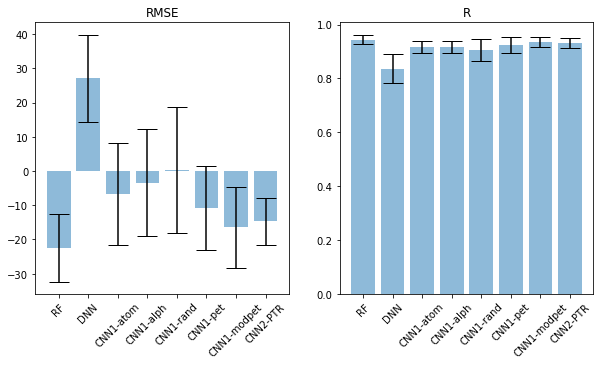

In [11]:
mean_rmse_list, std_rmse_list = [],[]
mean_r_list, std_r_list = [],[]
method_dict = ind_dict[20]
for method in method_dict.keys():
    test_rmse_mean = np.mean(method_dict[method]['rmse'])
    test_rmse_std = np.std(method_dict[method]['rmse'])
    test_r_mean = np.mean(method_dict[method]['r'])
    test_r_std = np.std(method_dict[method]['r'])
    mean_rmse_list.append(test_rmse_mean)
    std_rmse_list.append(test_rmse_std)
    mean_r_list.append(test_r_mean)
    std_r_list.append(test_r_std)
fig,ax = plt.subplots(1,2,figsize = (10,5))
ax = ax.ravel()
names = ['RF','DNN','CNN1-atom','CNN1-alph','CNN1-rand','CNN1-pet','CNN1-modpet','CNN2-PTR']
plot_titles = ['RMSE','R']
for i,(mean,std) in enumerate([(np.array(mean_rmse_list)-baseline_rmse,std_rmse_list),(mean_r_list,std_r_list)]):
    ax[i].bar(methods,mean,yerr=std,align='center', alpha=0.5, ecolor='black', capsize=10)
    ax[i].set_xticklabels(names, rotation=45)
    ax[i].set_title(plot_titles[i])

### Fixed variance

In [20]:
methods = ['RF','dense','atomic','random','random-tr','pettifor','mod_pettifor','PTR']
dset = data_generator_vec(pymatgen_comp(comps))
scoring_dict = get_scoring_dict()
var_result = {}
for v in var_dict.keys():
    print(f'{v*100}% variance')
    method_dict = {}
    mean_score_list = []
    std_score_list = []
    for i, method in enumerate(methods):
        if method == 'RF':
            features = dset.real_data
        else:
            ind = var_dict[v][method]
            if method == 'atomic':
                extracted = enc1d_features(comps,'atomic')
            elif method == 'random':
                extracted = enc1d_features(comps,'random')
            elif method == 'random-tr':
                extracted = enc1d_features(comps,'random-tr')
            elif method == 'pettifor':
                extracted = enc1d_features(comps,'pettifor')
            elif method == 'mod_pettifor':
                extracted = enc1d_features(comps,'mod_pettifor')
            elif method == 'PTR':
                extracted = get_PTR_features(comps)
            elif method =='dense':
                extracted = enc1d_features(comps,'dense')
            pca = PCA(n_components=ind, whiten=True)
            features = pca.fit_transform(extracted)
        #gridCV = GridSearchCV(RandomForestRegressor(), param_grid=param_grid,cv=10)
        
        rmse_list = []
        r_list = []
        for i in fold_dict.keys():
            pipe= Pipeline([('Scaler', StandardScaler()),('RF',RandomForestRegressor(random_state=0, n_jobs=-1))])
            i_tr, i_te = fold_dict[i]['train_inds'], fold_dict[i]['test_inds']
            X_train, X_test = features[i_tr], features[i_te]
            y_train, y_test = y[i_tr], y[i_te]
            pipe.fit(X_train,y_train)
            yte_pred=pipe.predict(X_test)
            #cv_results = cross_validate(pipe, features, y, cv=kfold, scoring=scoring_dict,return_train_score=True)
            #print(cv_results['test_r'])
            rmse_list.append(rmse(yte_pred,y_test))
            r_list.append(corr(yte_pred,y_test))
        method_dict[method] = {'rmse':rmse_list,'r':r_list}
    var_result[v] = method_dict

90.0% variance
95.0% variance
99.0% variance


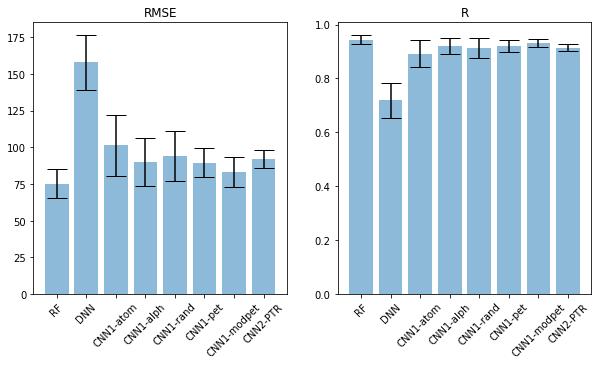

In [21]:
mean_rmse_list, std_rmse_list = [],[]
mean_r_list, std_r_list = [],[]
method_dict = var_result[0.95]
for method in method_dict.keys():
    test_rmse_mean = np.mean(method_dict[method]['rmse'])
    test_rmse_std = np.std(method_dict[method]['rmse'])
    test_r_mean = np.mean(method_dict[method]['r'])
    test_r_std = np.std(method_dict[method]['r'])
    mean_rmse_list.append(test_rmse_mean)
    std_rmse_list.append(test_rmse_std)
    mean_r_list.append(test_r_mean)
    std_r_list.append(test_r_std)
fig,ax = plt.subplots(1,2,figsize = (10,5))
ax = ax.ravel()
names = ['RF','DNN','CNN1-atom','CNN1-alph','CNN1-rand','CNN1-pet','CNN1-modpet','CNN2-PTR']
plot_titles = ['RMSE','R']
for i,(mean,std) in enumerate([(mean_rmse_list,std_rmse_list),(mean_r_list,std_r_list)]):
    ax[i].bar(methods,mean,yerr=std,align='center', alpha=0.5, ecolor='black', capsize=10)
    ax[i].set_xticklabels(names, rotation=45)
    ax[i].set_title(plot_titles[i])

In [22]:
hea_hardness_stat_dict = {}
hea_hardness_stat_dict['fixed_comps'] = ind_dict
hea_hardness_stat_dict['fixed_var'] = var_result

with open(os.path.join(results_loc,'hea_hardness_results.json'),'w') as fid:
    json.dump(hea_hardness_stat_dict,fid)

In [23]:
from itertools import combinations
from scipy.stats import ttest_ind, ttest_rel

methods = ['RF','dense','atomic','random','random-tr','pettifor','mod_pettifor','PTR']
p_value_dict_sup = {}
for k in hea_hardness_stat_dict.keys():
    p_value_dict = {}
    temp_dict = hea_hardness_stat_dict[k]
    for ti in temp_dict:
        zero = np.eye(len(methods))
        prediction_dict = temp_dict[ti]
        zero = np.zeros(len(methods))
        prediction_dict = temp_dict[ti]
        for i,key in enumerate(methods):
            a_score = np.array(list(prediction_dict[key]['rmse']))
            zero[i] = ttest_ind(a_score, baseline_rmse_list, alternative = 'two-sided',equal_var =False)[-1]
        p_value_dict[ti] = zero.tolist()
    
    p_value_dict_sup[k]=p_value_dict

In [24]:
with open(os.path.join(results_loc,'hea_hardness_statistical_test.json'),'w') as fid:
    json.dump(p_value_dict_sup,fid)

# Plots

## Fixed components

In [25]:
names = ['RF','DNN','CNN1-atom','CNN1-alph','CNN1-rand','CNN1-pet','CNN1-modpet','CNN2-PTR']

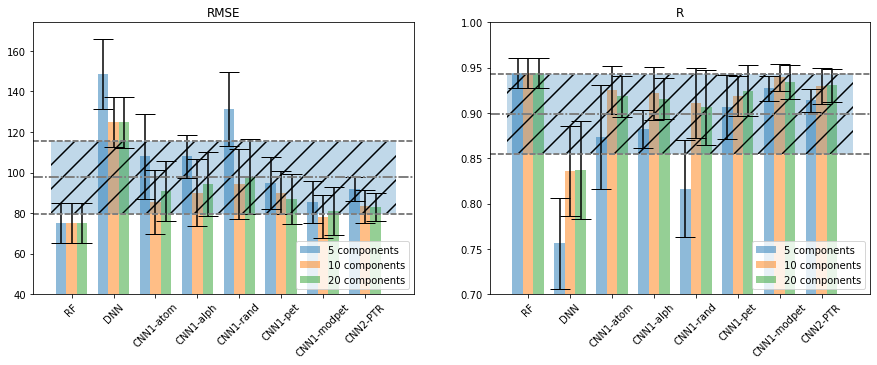

In [26]:
fig,ax = plt.subplots(1,2,figsize=(15,5), sharex=True)
mini_key = ['rmse','r']

temp_dict = hea_hardness_stat_dict['fixed_comps']
barWidth = 0.25
for j in range(2):
        
        for ind,k in enumerate(temp_dict.keys()):
            mean_scores = []
            std_scores = []
            spec_dict = temp_dict[k]
            for ind2,method in enumerate(spec_dict.keys()):
                mean_scores.append(np.mean(temp_dict[k][method][mini_key[j]]))
                std_scores.append(np.std(temp_dict[k][method][mini_key[j]]))
            x = np.arange(len(mean_scores))
            x_mod = ind*barWidth + x
            ax[j].bar(x_mod, mean_scores, yerr = std_scores,align='center', alpha=0.5, ecolor='black', 
    capsize=10, width=barWidth, label = f'{k} components')
            ax[j].set_xticks(np.arange(0.25,len(x)+0.25,1),labels = names, rotation=45)
            ax[j].set_title(mini_key[j].upper())
            ax[j].legend(loc='lower right')
            if mini_key[j] == 'rmse':
                ax[j].axhline(baseline_rmse - baseline_rmse_std,linestyle='dashed',c='grey')
                ax[j].axhline(baseline_rmse,linestyle='-.',c='grey')
                ax[j].axhline(baseline_rmse + baseline_rmse_std,linestyle='dashed',c='grey')
                ax[j].add_patch(Rectangle((0-barWidth, baseline_rmse-baseline_rmse_std), 8+barWidth, 2*baseline_rmse_std, hatch = '/', alpha = 0.1))
                ax[j].set_ylim(40)
                #ax[j].set_ylim(1)
            else:
                ax[j].axhline(baseline_r - baseline_r_std,linestyle='dashed',c='grey')
                ax[j].axhline(baseline_r,linestyle='-.',c='grey')
                ax[j].axhline(baseline_r + baseline_r_std,linestyle='dashed',c='grey')
                ax[j].add_patch(Rectangle((0-barWidth, baseline_r-baseline_r_std), 8+barWidth, 2*baseline_r_std, hatch = '/', alpha = 0.1))
                ax[j].set_ylim(0.7,1)
plt.subplots_adjust(hspace=0.5)



## Fixed variance

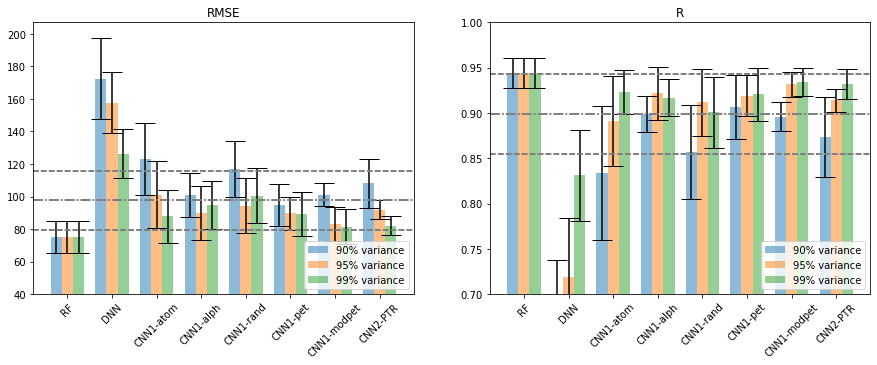

In [27]:
fig,ax = plt.subplots(1,2,figsize=(15,5), sharex=True)
mini_key = ['rmse','r']

temp_dict = hea_hardness_stat_dict['fixed_var']
barWidth = 0.25
for j in range(2):
        
        for ind,k in enumerate(temp_dict.keys()):
            mean_scores = []
            std_scores = []
            spec_dict = temp_dict[k]
            for ind2,method in enumerate(spec_dict.keys()):
                mean_scores.append(np.mean(temp_dict[k][method][mini_key[j]]))
                std_scores.append(np.std(temp_dict[k][method][mini_key[j]]))
            x = np.arange(len(mean_scores))
            x_mod = ind*barWidth + x
            ax[j].bar(x_mod, mean_scores, yerr = std_scores,align='center', alpha=0.5, ecolor='black', 
    capsize=10, width=barWidth, label = f'{int(k*100)}% variance',)
            ax[j].set_xticks(np.arange(0.25,len(x)+0.25,1),labels = names, rotation=45)
            ax[j].set_title(mini_key[j].upper())
            ax[j].legend(loc='lower right')
            if mini_key[j] == 'rmse':
                ax[j].axhline(baseline_rmse - baseline_rmse_std,linestyle='dashed',c='grey')
                ax[j].axhline(baseline_rmse,linestyle='-.',c='grey')
                ax[j].axhline(baseline_rmse + baseline_rmse_std,linestyle='dashed',c='grey')
                ax[j].set_ylim(40)
            else:
                ax[j].axhline(baseline_r - baseline_r_std,linestyle='dashed',c='grey')
                ax[j].axhline(baseline_r,linestyle='-.',c='grey')
                ax[j].axhline(baseline_r + baseline_r_std,linestyle='dashed',c='grey')
                ax[j].set_ylim(0.7,1)
plt.subplots_adjust(hspace=0.5)

## Statistical test

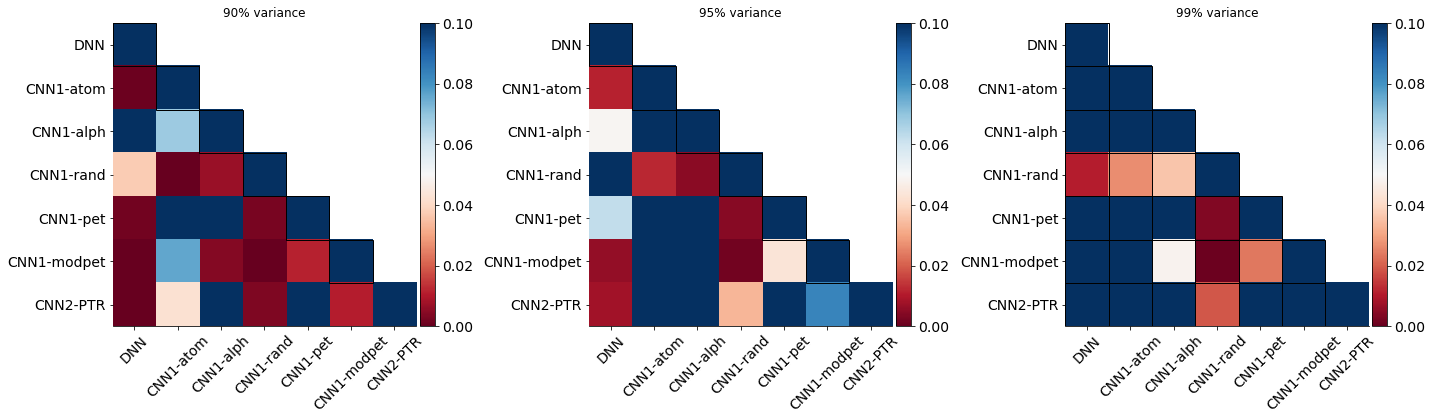

In [12]:
from matplotlib import cm as cm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

def highlight_cell(x,y, ax=None, **kwargs):
    rect = plt.Rectangle((x-.5, y-.5), 1,1, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect

to_plot_dict = p_value_dict_sup['fixed_var']
fig,ax = plt.subplots(1,3,figsize = (20,7))
ax = ax.ravel()
for i, k in enumerate(to_plot_dict.keys()):
    zero = np.array(to_plot_dict[k])
    mask =  np.tri(zero.T.shape[0], k=-1)
    A = np.ma.array(zero, mask=mask).T
    truth = np.where(mask == 1)
    ax[i].set_xticks(np.arange(0, len(names), 1))
    ax[i].set_yticks(np.arange(0, len(names), 1))

    cmap = cm.get_cmap('RdBu')
    im = ax[i].imshow(A, cmap = cmap, vmin = 0, vmax = 0.1)
    for j in range(len(truth[0])):
            highlight_cell(truth[1][j],truth[0][j])
    diag = [0,1,2,3,4,5]
    for d in diag:
            highlight_cell(d,d, ax[i])
    ax[i].set_xticklabels(names, rotation = 45, fontsize = 14)
    ax[i].set_yticklabels(names, fontsize = 14)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['bottom'].set_visible(True)
    ax[i].spines['left'].set_visible(False)
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cb=fig.colorbar(im, cax=cax, orientation='vertical',fraction=0.046, pad=0.04)
    ax[i].set_title(f'{int(k*100)}% variance')
    #cb = plt.colorbar(im,fraction=0.046, pad=0.04, cax=ax[i])
    for t in cb.ax.get_yticklabels():
            t.set_fontsize(14)

    #ax[i].text(-0.4, 1.1, key, transform=ax[i].transAxes, size=20, weight='bold')
plt.tight_layout()

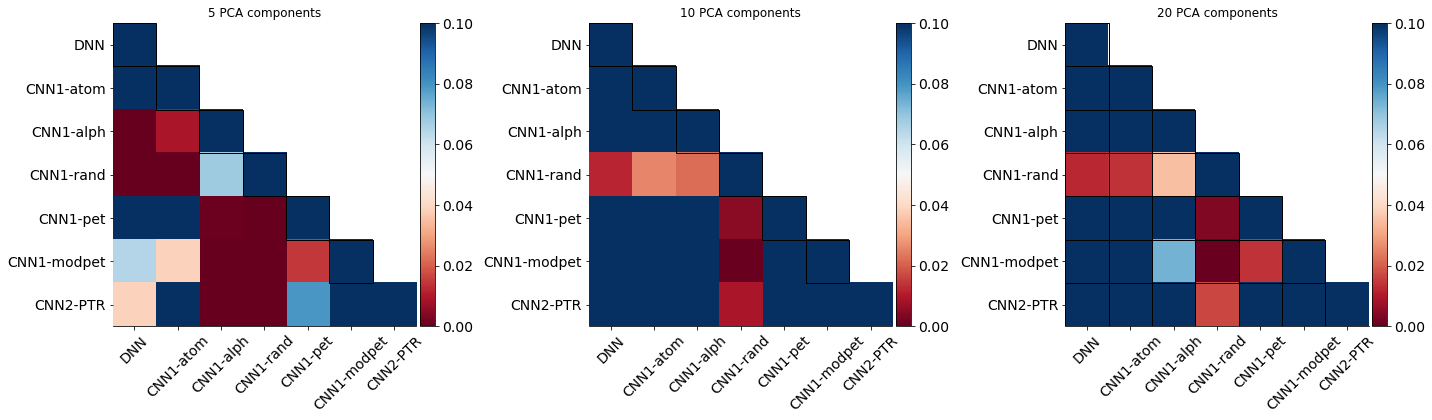

In [13]:
from matplotlib import cm as cm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

def highlight_cell(x,y, ax=None, **kwargs):
    rect = plt.Rectangle((x-.5, y-.5), 1,1, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect

to_plot_dict = p_value_dict_sup['fixed_comps']
fig,ax = plt.subplots(1,3,figsize = (20,7))
ax = ax.ravel()
for i, k in enumerate(to_plot_dict.keys()):
    zero = np.array(to_plot_dict[k])
    mask =  np.tri(zero.T.shape[0], k=-1)
    A = np.ma.array(zero, mask=mask).T
    truth = np.where(mask == 1)
    ax[i].set_xticks(np.arange(0, len(names), 1))
    ax[i].set_yticks(np.arange(0, len(names), 1))

    cmap = cm.get_cmap('RdBu')
    im = ax[i].imshow(A, cmap = cmap, vmin = 0, vmax = 0.1)
    for j in range(len(truth[0])):
            highlight_cell(truth[1][j],truth[0][j])
    diag = [0,1,2,3,4,5]
    for d in diag:
            highlight_cell(d,d, ax[i])
    ax[i].set_xticklabels(names, rotation = 45, fontsize = 14)
    ax[i].set_yticklabels(names, fontsize = 14)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['bottom'].set_visible(True)
    ax[i].spines['left'].set_visible(False)
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cb=fig.colorbar(im, cax=cax, orientation='vertical',fraction=0.046, pad=0.04)
    ax[i].set_title(f'{int(k)} PCA components')
    #cb = plt.colorbar(im,fraction=0.046, pad=0.04, cax=ax[i])
    for t in cb.ax.get_yticklabels():
            t.set_fontsize(14)

    #ax[i].text(-0.4, 1.1, key, transform=ax[i].transAxes, size=20, weight='bold')
plt.tight_layout()

In [123]:
with open('results/hea_hardness_statistical_test.json','w') as fid:
    json.dump(p_value_dict_sup,fid)